# 1.EDS

In [ ]:
# 1. 분석 목표 : 건물 정보와 기후 정보를 이용하여 전력사용량 예측

# num : 건물 별 모델링 필요 (1 ~ 60)(비전기냉방설비운영, 태양광보유)
# 변수명 변경 : cols = ['num', 'date_time', 'power', 'temp', 'wind','hum' ,'prec', 'sun', 'non_elec', 'solar']
# 건물별, 요일별, 시간대별
# 유사한 건물은 그룹핑?


# test : 2020.08.25~2020.08.31
  # 기온, 풍속, 습도, 일조 3시간 주기 측정
  # 강수량 6시간 주기 측정
  # 결측치 추가
  # 건물변수 : '비전기냉방설비운영', '태양광보유'

# train : 2020.06.01~2020.08.24
  # 1시간 단위 측정
  # 결측치가 채워진 규칙으로 test의 결측치도 채워넣어야 함.

# 주중과 주말, 휴일 차이 확인?
# 건물 별 차이 확인?


# 시계열 분석
# 건물 별 시간에 따른 전력사용량 시각화



In [ ]:
# 한글 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
# 메뉴 - 런타임 - 세션 다시 시작
import matplotlib.pyplot as plt
# 한글 폰트 지정
plt.rc("font", family = "NanumGothic")
# 스타일 서식 적용
plt.style.use('ggplot')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
import pandas as pd
import numpy as np
import math

#Visualizing
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'; plt.rcParams['axes.unicode_minus'] = False;
import seaborn as sns; #sns.set_style('whitegrid')

#Time Series Analysis
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Clustering (+α)
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler


#Modeling
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

#System
from ipywidgets import interact
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')


In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'  # 사용할 한글 폰트 설정

In [ ]:
sample = pd.read_csv("/content/drive/MyDrive/LS빅데이터스쿨/프로젝트/2주차/sample_submission.csv")
test = pd.read_csv("/content/drive/MyDrive/LS빅데이터스쿨/프로젝트/2주차/test.csv", encoding='cp949',parse_dates=['date_time'])
train = pd.read_csv("/content/drive/MyDrive/LS빅데이터스쿨/프로젝트/2주차/train.csv", encoding='cp949',parse_dates=['date_time'])

print(sample.head())
print(test.head())
print(train.head())

     num_date_time  answer
0  1 2020-08-25 00       0
1  1 2020-08-25 01       0
2  1 2020-08-25 02       0
3  1 2020-08-25 03       0
4  1 2020-08-25 04       0
   num           date_time  기온(°C)  풍속(m/s)  습도(%)  강수량(mm, 6시간)  일조(hr, 3시간)  \
0    1 2020-08-25 00:00:00    27.8      1.5   74.0           0.0          0.0   
1    1 2020-08-25 01:00:00     NaN      NaN    NaN           NaN          NaN   
2    1 2020-08-25 02:00:00     NaN      NaN    NaN           NaN          NaN   
3    1 2020-08-25 03:00:00    27.3      1.1   78.0           NaN          0.0   
4    1 2020-08-25 04:00:00     NaN      NaN    NaN           NaN          NaN   

   비전기냉방설비운영  태양광보유  
0        NaN    NaN  
1        NaN    NaN  
2        NaN    NaN  
3        NaN    NaN  
4        NaN    NaN  
   num           date_time  전력사용량(kWh)  기온(°C)  풍속(m/s)  습도(%)  강수량(mm)  \
0    1 2020-06-01 00:00:00    8179.056    17.6      2.5   92.0      0.8   
1    1 2020-06-01 01:00:00    8135.640    17.7      2.9   91.0      0

In [ ]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   num_date_time  10080 non-null  object
 1   answer         10080 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 157.6+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   num           10080 non-null  int64         
 1   date_time     10080 non-null  datetime64[ns]
 2   기온(°C)        3360 non-null   float64       
 3   풍속(m/s)       3360 non-null   float64       
 4   습도(%)         3360 non-null   float64       
 5   강수량(mm, 6시간)  1680 non-null   float64       
 6   일조(hr, 3시간)   3360 non-null   float64       
 7   비전기냉방설비운영     2296 non-null   float64       
 8   태양광보유         1624 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 708.9 KB


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   num         122400 non-null  int64         
 1   date_time   122400 non-null  datetime64[ns]
 2   전력사용량(kWh)  122400 non-null  float64       
 3   기온(°C)      122400 non-null  float64       
 4   풍속(m/s)     122400 non-null  float64       
 5   습도(%)       122400 non-null  float64       
 6   강수량(mm)     122400 non-null  float64       
 7   일조(hr)      122400 non-null  float64       
 8   비전기냉방설비운영   122400 non-null  float64       
 9   태양광보유       122400 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 9.3 MB


In [ ]:
test.isnull().sum()

num                0
date_time          0
기온(°C)          6720
풍속(m/s)         6720
습도(%)           6720
강수량(mm, 6시간)    8400
일조(hr, 3시간)     6720
비전기냉방설비운영       7784
태양광보유           8456
dtype: int64

In [ ]:
!pip install statsmodels pandas
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

## 1-1.결측치 처리

In [ ]:
# 건물별 '비전기냉방설비운영', '태양광보유' 변수 동일 -> train_df의 데이터를 test_df에 채움

building_info = train[['num','비전기냉방설비운영', '태양광보유']].drop_duplicates()

test.drop(columns=['비전기냉방설비운영', '태양광보유'], inplace = True)
test = pd.merge(test, building_info, on= 'num')

test

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00:00:00,27.8,1.5,74.0,0.0,0.0,0.0,0.0
1,1,2020-08-25 01:00:00,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,1,2020-08-25 02:00:00,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,1,2020-08-25 03:00:00,27.3,1.1,78.0,NaN,0.0,0.0,0.0
4,1,2020-08-25 04:00:00,NaN,NaN,NaN,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19:00:00,NaN,NaN,NaN,NaN,NaN,1.0,1.0
10076,60,2020-08-31 20:00:00,NaN,NaN,NaN,NaN,NaN,1.0,1.0
10077,60,2020-08-31 21:00:00,27.9,4.1,68.0,NaN,0.0,1.0,1.0
10078,60,2020-08-31 22:00:00,NaN,NaN,NaN,NaN,NaN,1.0,1.0


## 1-2.train의 전력량 그래프 확인

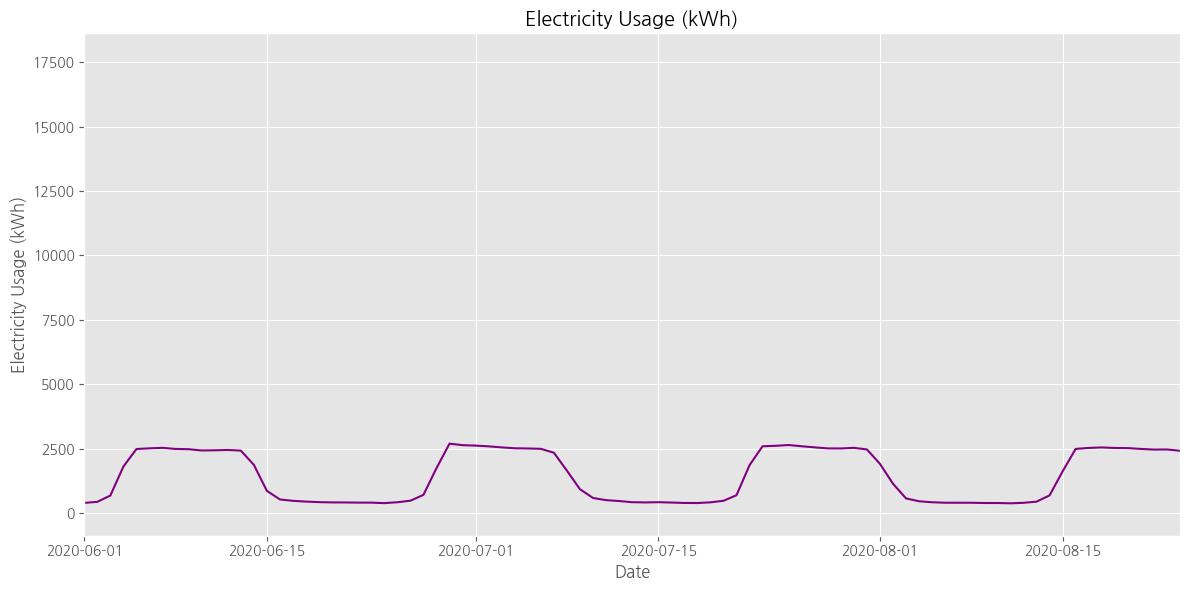

In [ ]:
import matplotlib.pyplot as plt

# 그래프 크기 설정
plt.figure(figsize=(12, 6))

# 전력사용량 그래프
plt.plot(train.index, train['전력사용량(kWh)'], color='purple')
plt.title('Electricity Usage (kWh)')
plt.xlabel('Date')
plt.ylabel('Electricity Usage (kWh)')

# x 축 범위 설정 (예: 2020-06-01부터 2020-08-24까지)
plt.xlim(pd.Timestamp('2020-06-01'), pd.Timestamp('2020-08-24'))

plt.tight_layout()  # 그래프 간격 조절
plt.show()

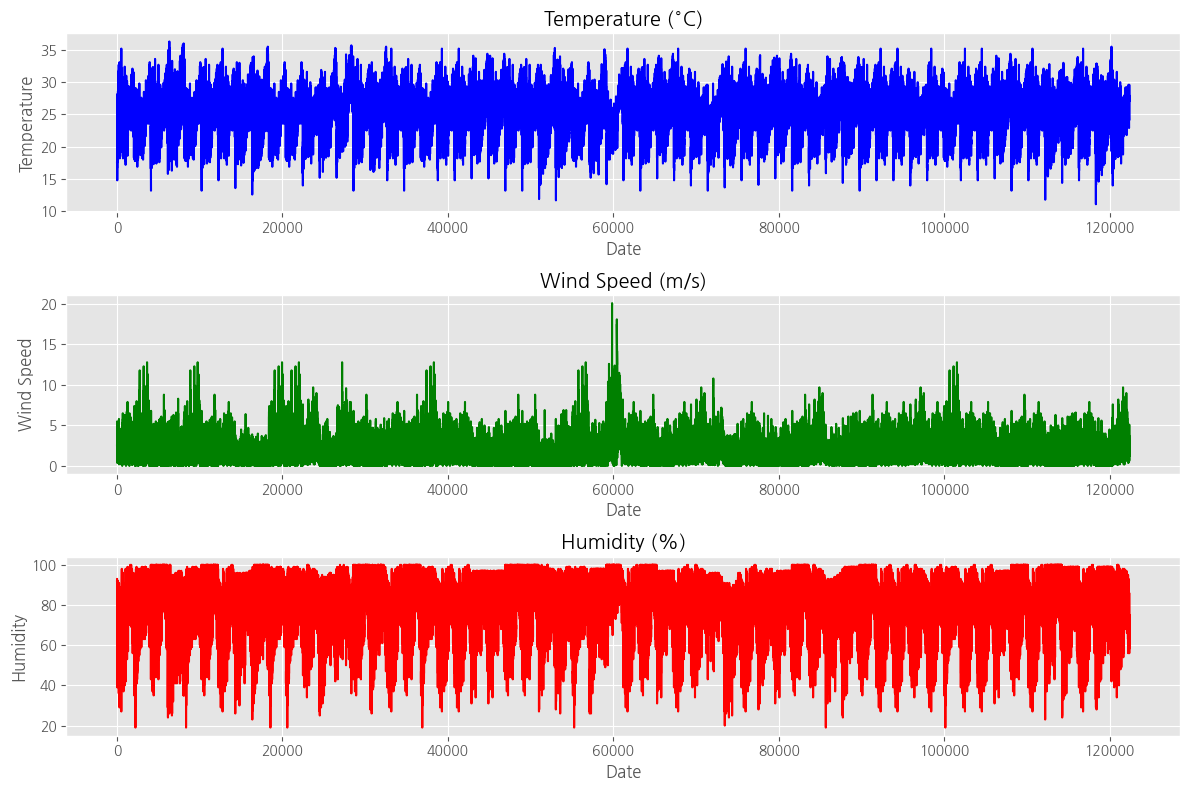

In [ ]:
import matplotlib.pyplot as plt

# 그래프 크기 설정
plt.figure(figsize=(12, 8))

# 기온 그래프
plt.subplot(3, 1, 1)  # (행, 열, 인덱스)
plt.plot(train.index, train['기온(°C)'], color='blue')
plt.title('Temperature (°C)')
plt.xlabel('Date')
plt.ylabel('Temperature')

# 풍속 그래프
plt.subplot(3, 1, 2)
plt.plot(train.index, train['풍속(m/s)'], color='green')
plt.title('Wind Speed (m/s)')
plt.xlabel('Date')
plt.ylabel('Wind Speed')

# 습도 그래프
plt.subplot(3, 1, 3)
plt.plot(train.index, train['습도(%)'], color='red')
plt.title('Humidity (%)')
plt.xlabel('Date')
plt.ylabel('Humidity')

plt.tight_layout()  # 그래프 간격 조절
plt.show()

## 1-3.건물별 전력사용량

<Axes: xlabel='전력사용량(kWh)', ylabel='Count'>

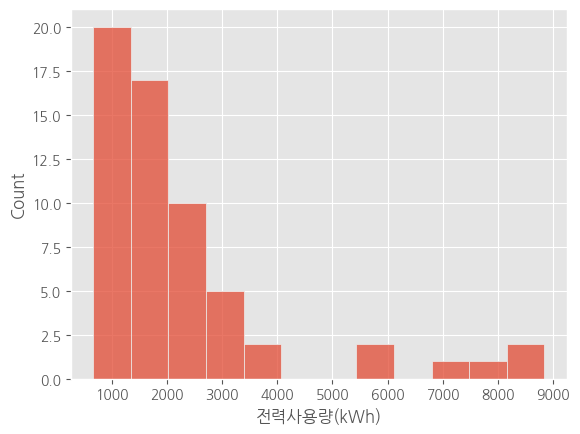

In [ ]:
sns.histplot(train.groupby('num')['전력사용량(kWh)'].mean())

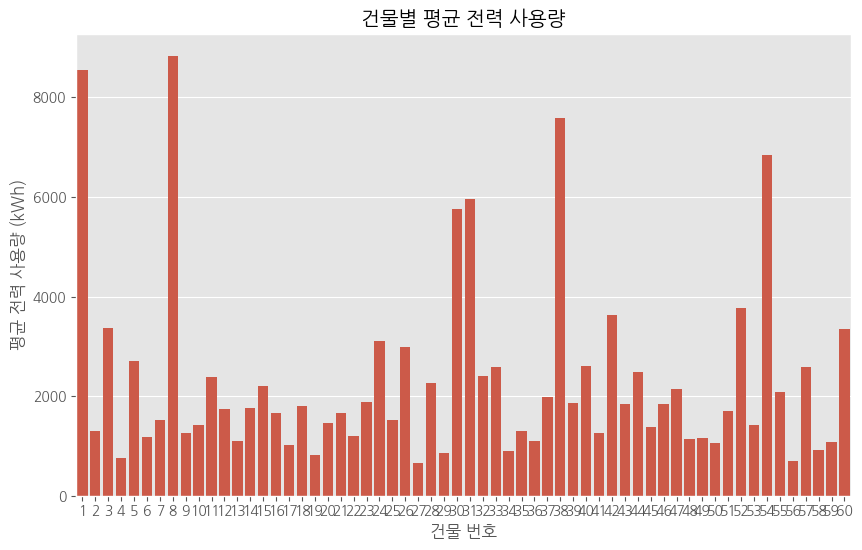

In [ ]:
# 각 건물별 평균 전력 사용량 계산
mean_power_usage = train.groupby('num')['전력사용량(kWh)'].mean().reset_index()

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='num', y='전력사용량(kWh)', data=mean_power_usage)
plt.title('건물별 평균 전력 사용량')
plt.xlabel('건물 번호')
plt.ylabel('평균 전력 사용량 (kWh)')
plt.show()

In [ ]:
#요일
def weekday(x):
    if x.dayofweek == 6:
        return '일'
    elif x.dayofweek == 0:
        return '월'
    elif x.dayofweek == 1:
        return '화'
    elif x.dayofweek == 2:
        return '수'
    elif x.dayofweek == 3:
        return '목'
    elif x.dayofweek == 4:
        return '금'
    else:
        return '토'

# 주말 여부
def weekend(x):
    if x.dayofweek in [5, 6]:
        return 1
    else:
        return 0

In [ ]:
train['month'] = train['date_time'].dt.month.astype(float)
train['day'] = train['date_time'].dt.day.astype(float)
train['hour'] = train['date_time'].dt.hour.astype(float)
train['weekday'] = train['date_time'].apply(weekday)
train['weekend'] = train['date_time'].apply(weekend).astype(float)

test['month'] = test['date_time'].dt.month.astype(float)
test['day'] = test['date_time'].dt.day.astype(float)
test['hour'] = test['date_time'].dt.hour.astype(float)
test['weekday'] = test['date_time'].apply(weekday)
test['weekend'] = test['date_time'].apply(weekend).astype(float)

In [ ]:
train.day = pd.to_datetime(train.day)
print(train.head())
print(train.info())

   num           date_time  전력사용량(kWh)  기온(°C)  풍속(m/s)  습도(%)  강수량(mm)  \
0    1 2020-06-01 00:00:00    8179.056    17.6      2.5   92.0      0.8   
1    1 2020-06-01 01:00:00    8135.640    17.7      2.9   91.0      0.3   
2    1 2020-06-01 02:00:00    8107.128    17.5      3.2   91.0      0.0   
3    1 2020-06-01 03:00:00    8048.808    17.1      3.2   91.0      0.0   
4    1 2020-06-01 04:00:00    8043.624    17.0      3.3   92.0      0.0   

   일조(hr)  비전기냉방설비운영  태양광보유  month                           day  hour  \
0     0.0        0.0    0.0      6 1970-01-01 00:00:00.000000001     0   
1     0.0        0.0    0.0      6 1970-01-01 00:00:00.000000001     1   
2     0.0        0.0    0.0      6 1970-01-01 00:00:00.000000001     2   
3     0.0        0.0    0.0      6 1970-01-01 00:00:00.000000001     3   
4     0.0        0.0    0.0      6 1970-01-01 00:00:00.000000001     4   

  weekday  weekend  
0       월        0  
1       월        0  
2       월        0  
3       월        0  

In [ ]:
train

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,month,day,hour,weekend,weekday
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,6.0,1.0,0.0,0.0,월
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,6.0,1.0,1.0,0.0,월
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,6.0,1.0,2.0,0.0,월
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,6.0,1.0,3.0,0.0,월
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,6.0,1.0,4.0,0.0,월
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19:00:00,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0,8.0,24.0,19.0,0.0,월
122396,60,2020-08-24 20:00:00,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0,8.0,24.0,20.0,0.0,월
122397,60,2020-08-24 21:00:00,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0,8.0,24.0,21.0,0.0,월
122398,60,2020-08-24 22:00:00,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0,8.0,24.0,22.0,0.0,월


In [ ]:
train.drop(columns=['weekday'], inplace=True)

In [ ]:
train

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,month,day,hour,weekend
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,6.0,1.0,0.0,0.0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,6.0,1.0,1.0,0.0
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,6.0,1.0,2.0,0.0
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,6.0,1.0,3.0,0.0
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,6.0,1.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19:00:00,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0,8.0,24.0,19.0,0.0
122396,60,2020-08-24 20:00:00,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0,8.0,24.0,20.0,0.0
122397,60,2020-08-24 21:00:00,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0,8.0,24.0,21.0,0.0
122398,60,2020-08-24 22:00:00,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0,8.0,24.0,22.0,0.0


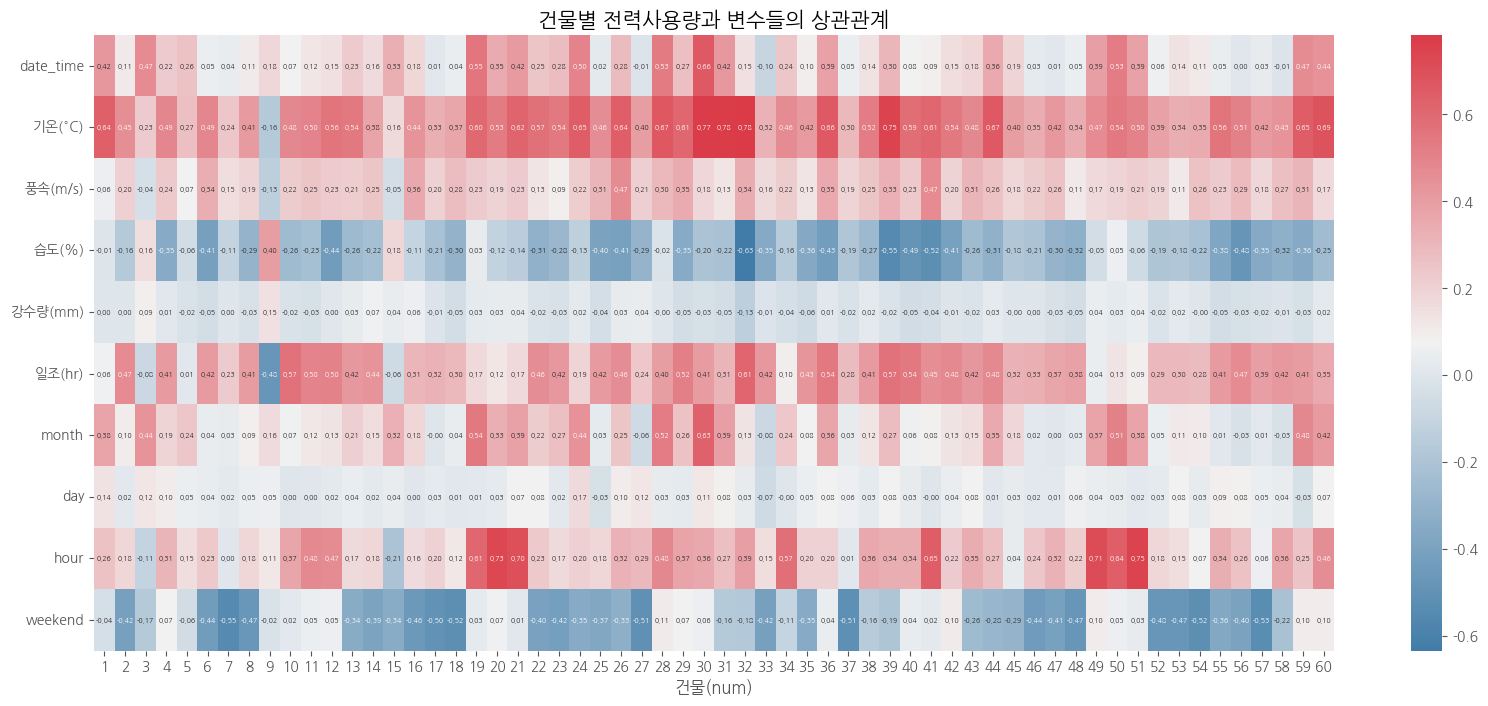

In [ ]:
corr = []
for num in range(1,61):
    df = train[train.num==num]
    num_corr = df.corr()['전력사용량(kWh)']
    num_corr = num_corr.drop(['num','비전기냉방설비운영','태양광보유','전력사용량(kWh)'])
    corr.append(num_corr)
corr_df = pd.concat(corr, axis=1).T
corr_df.index = list(range(1,61))

# 시각화
f, ax = plt.subplots(figsize=(20,8))
plt.title("건물별 전력사용량과 변수들의 상관관계", fontsize=15)
sns.heatmap(corr_df.T, cmap=sns.diverging_palette(240,10,as_cmap=True), annot=True, fmt='.2f', ax=ax, annot_kws={'size': 5})  # annot_kws로 글자 크기 조정
plt.xlabel('건물(num)')
plt.show()

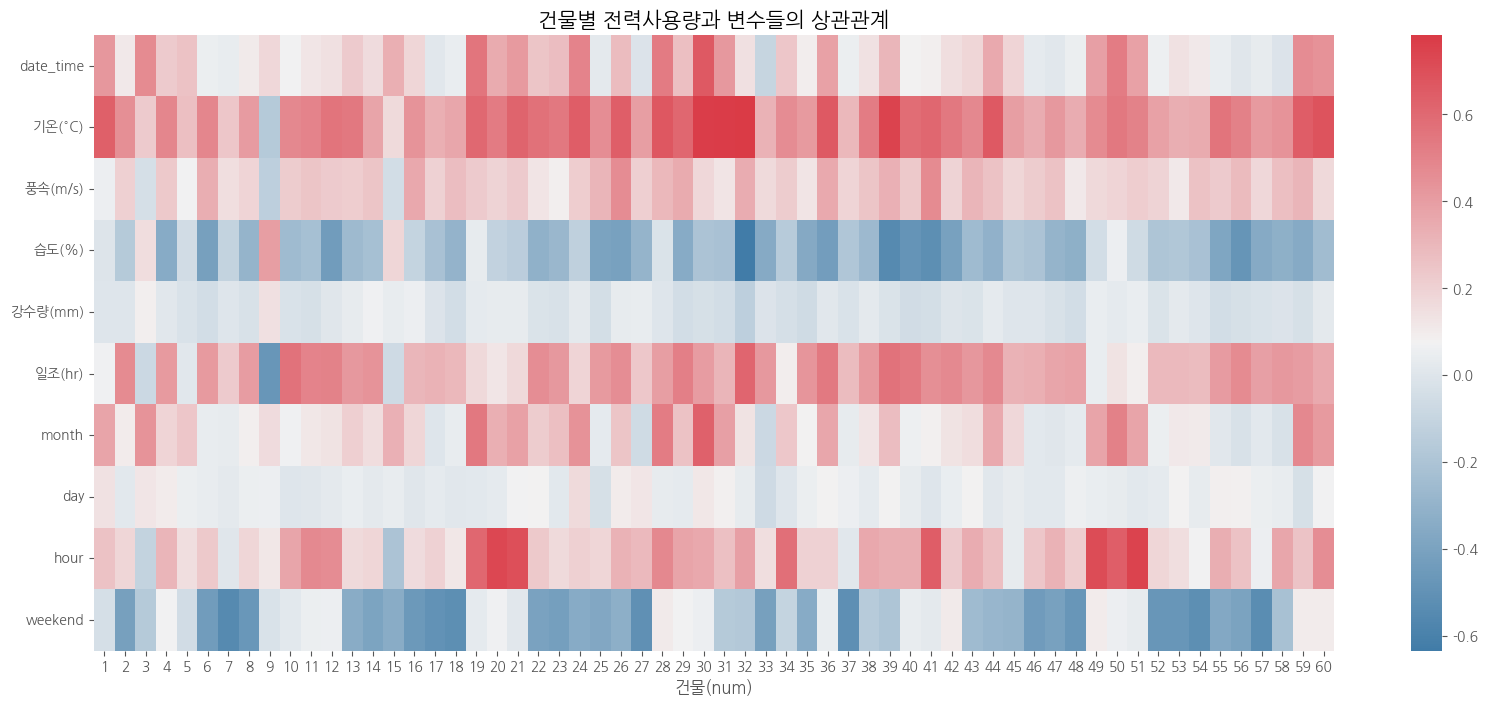

In [ ]:
corr = []
for num in range(1,61):
    df = train[train.num==num]
    num_corr = df.corr()['전력사용량(kWh)']
    num_corr = num_corr.drop(['num','비전기냉방설비운영','태양광보유','전력사용량(kWh)'])
    corr.append(num_corr)
corr_df = pd.concat(corr, axis=1).T
corr_df.index = list(range(1,61))

# 시각화
f, ax = plt.subplots(figsize=(20,8))
plt.title("건물별 전력사용량과 변수들의 상관관계", fontsize=15)
sns.heatmap(corr_df.T, cmap=sns.diverging_palette(240,10,as_cmap=True), ax=ax)
plt.xlabel('건물(num)')
plt.show()

# 2.시계열 분석

## 2-1. 시계열 데이터

In [ ]:
def vis_time_series_decompose(num):
    df = train[train.num==num]
    df.index = df.date_time

    res = sm.tsa.seasonal_decompose(df['전력사용량(kWh)'], model='additive')

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
    res.observed.plot(ax=ax1, title='Observed')  # 관측치
    res.trend.plot(ax=ax2, title='Trend')        # 추세
    res.resid.plot(ax=ax3, title='Residual')     # 잔차
    res.seasonal.plot(ax=ax4, title='Seasonal')  # 계절성
    plt.tight_layout()
    plt.show()

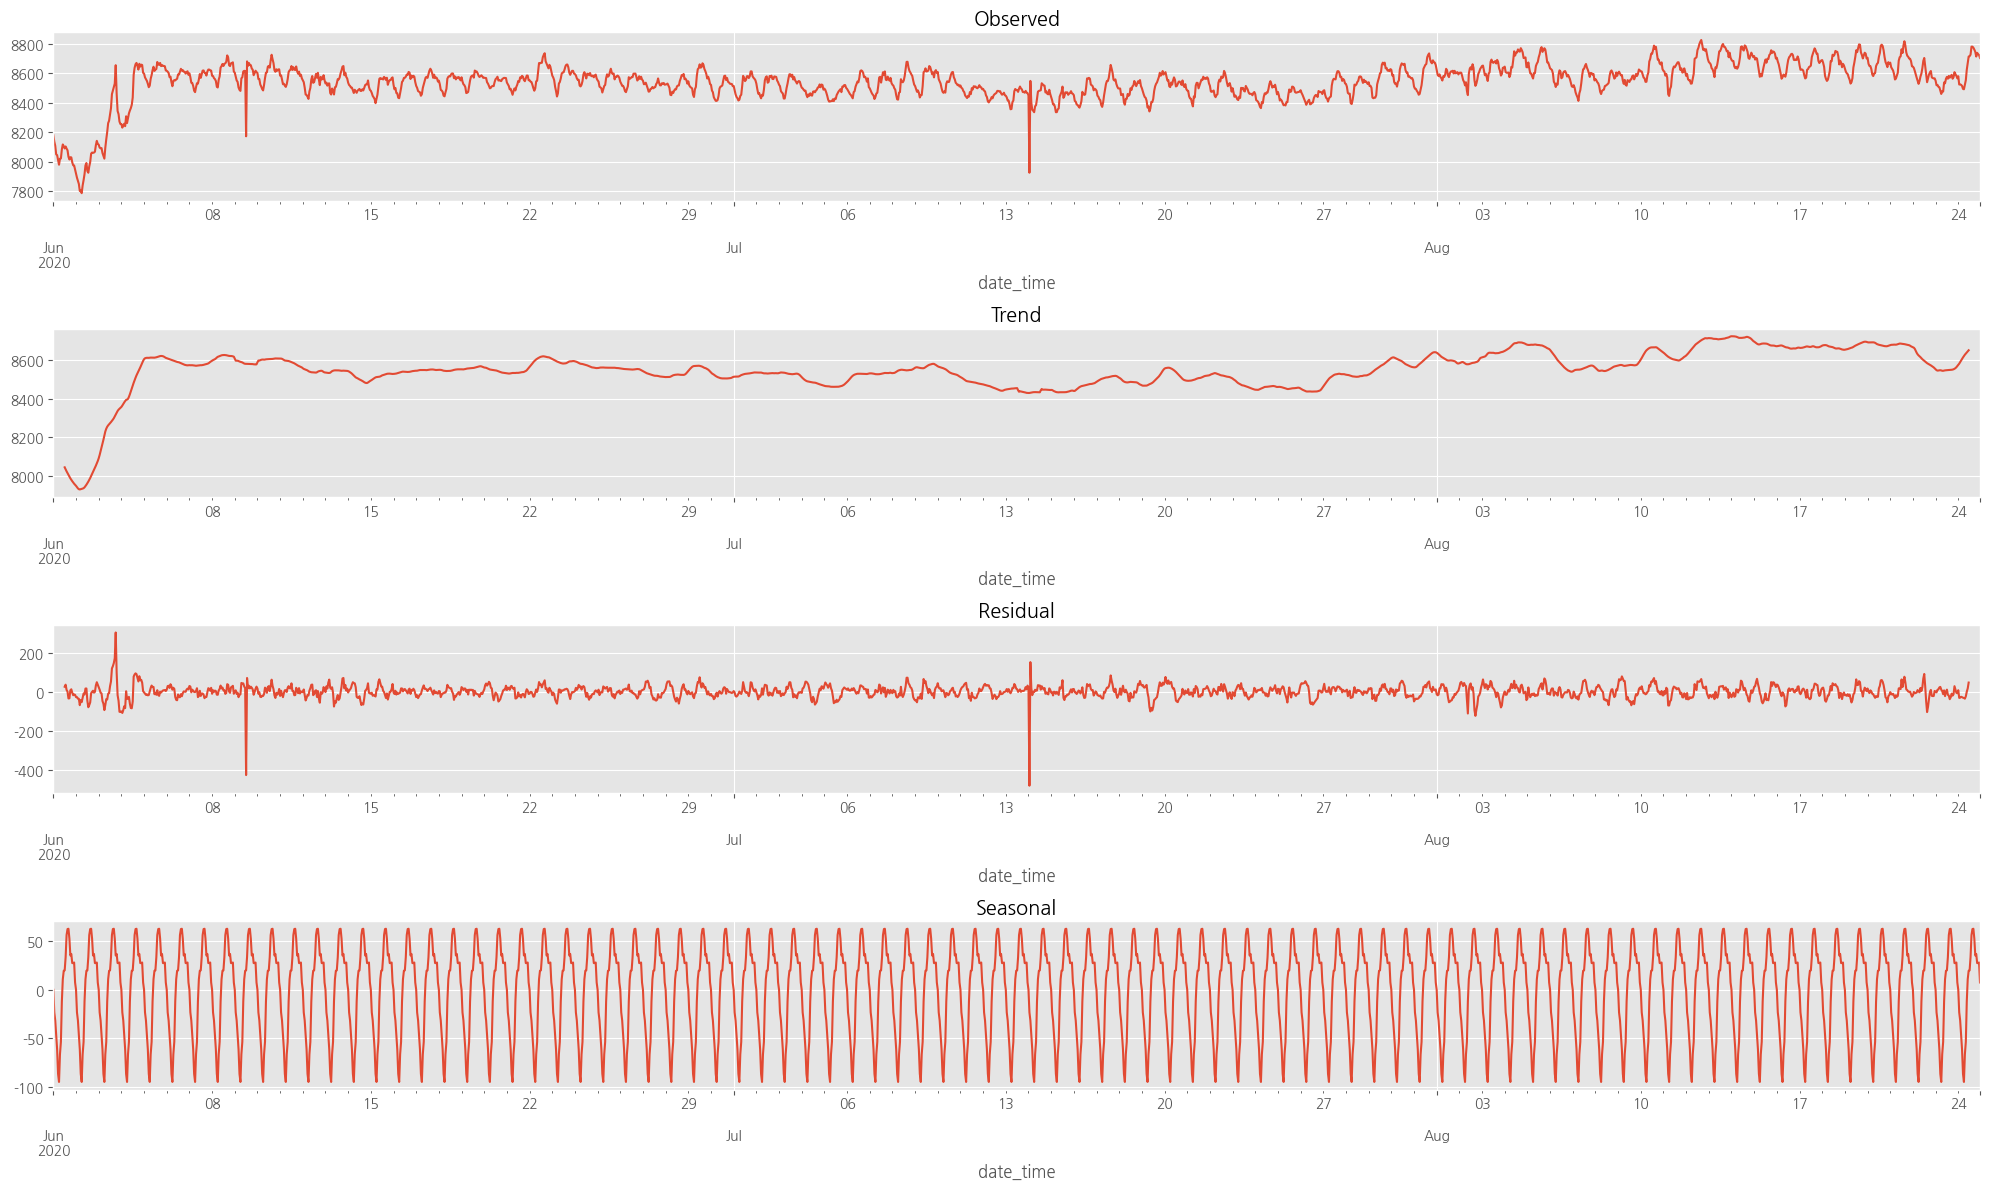

In [ ]:
## 건물1
vis_time_series_decompose(num=1)

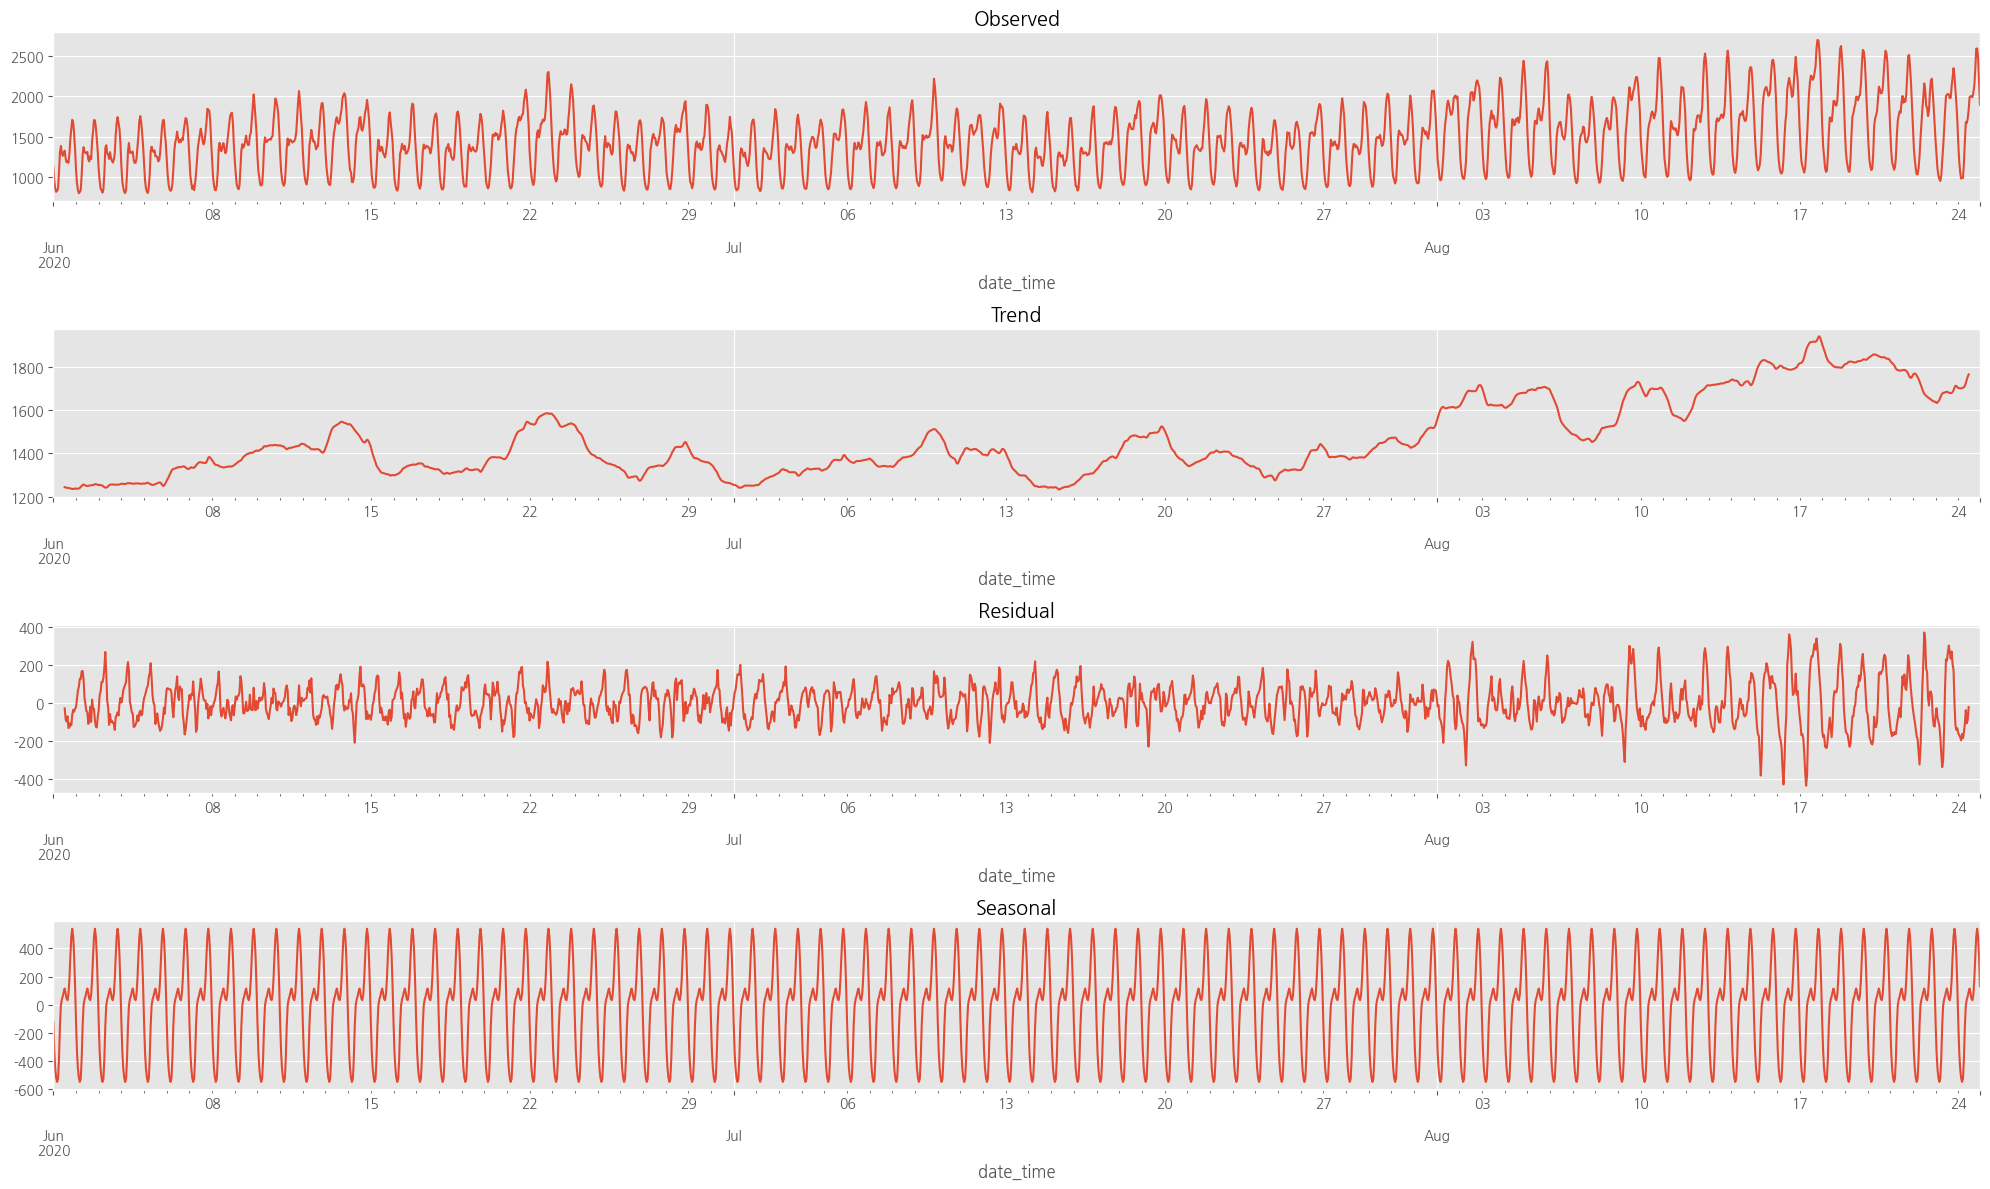

In [ ]:
## 건물20
vis_time_series_decompose(num=20)

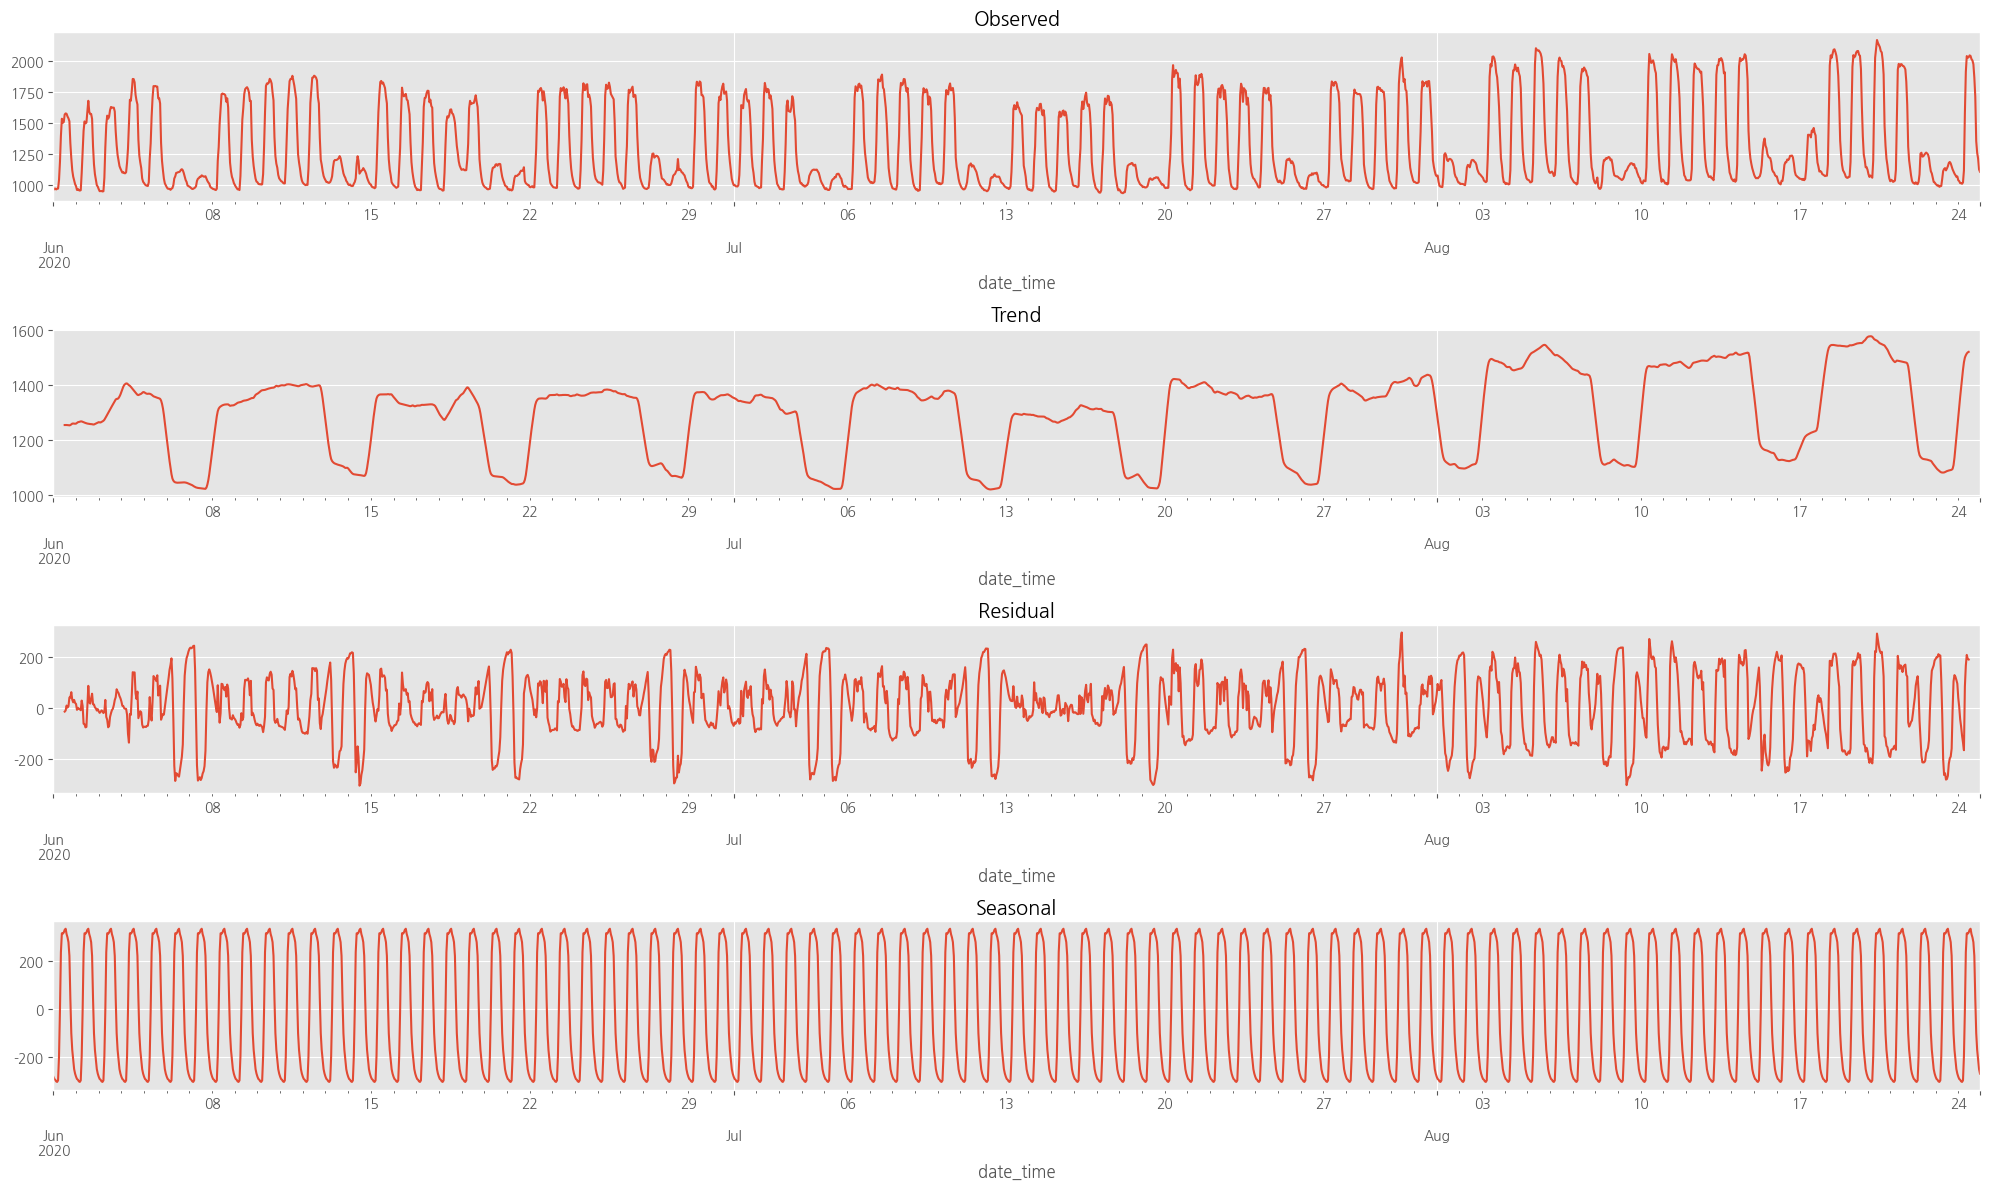

In [ ]:
## 건물2
vis_time_series_decompose(num=2)

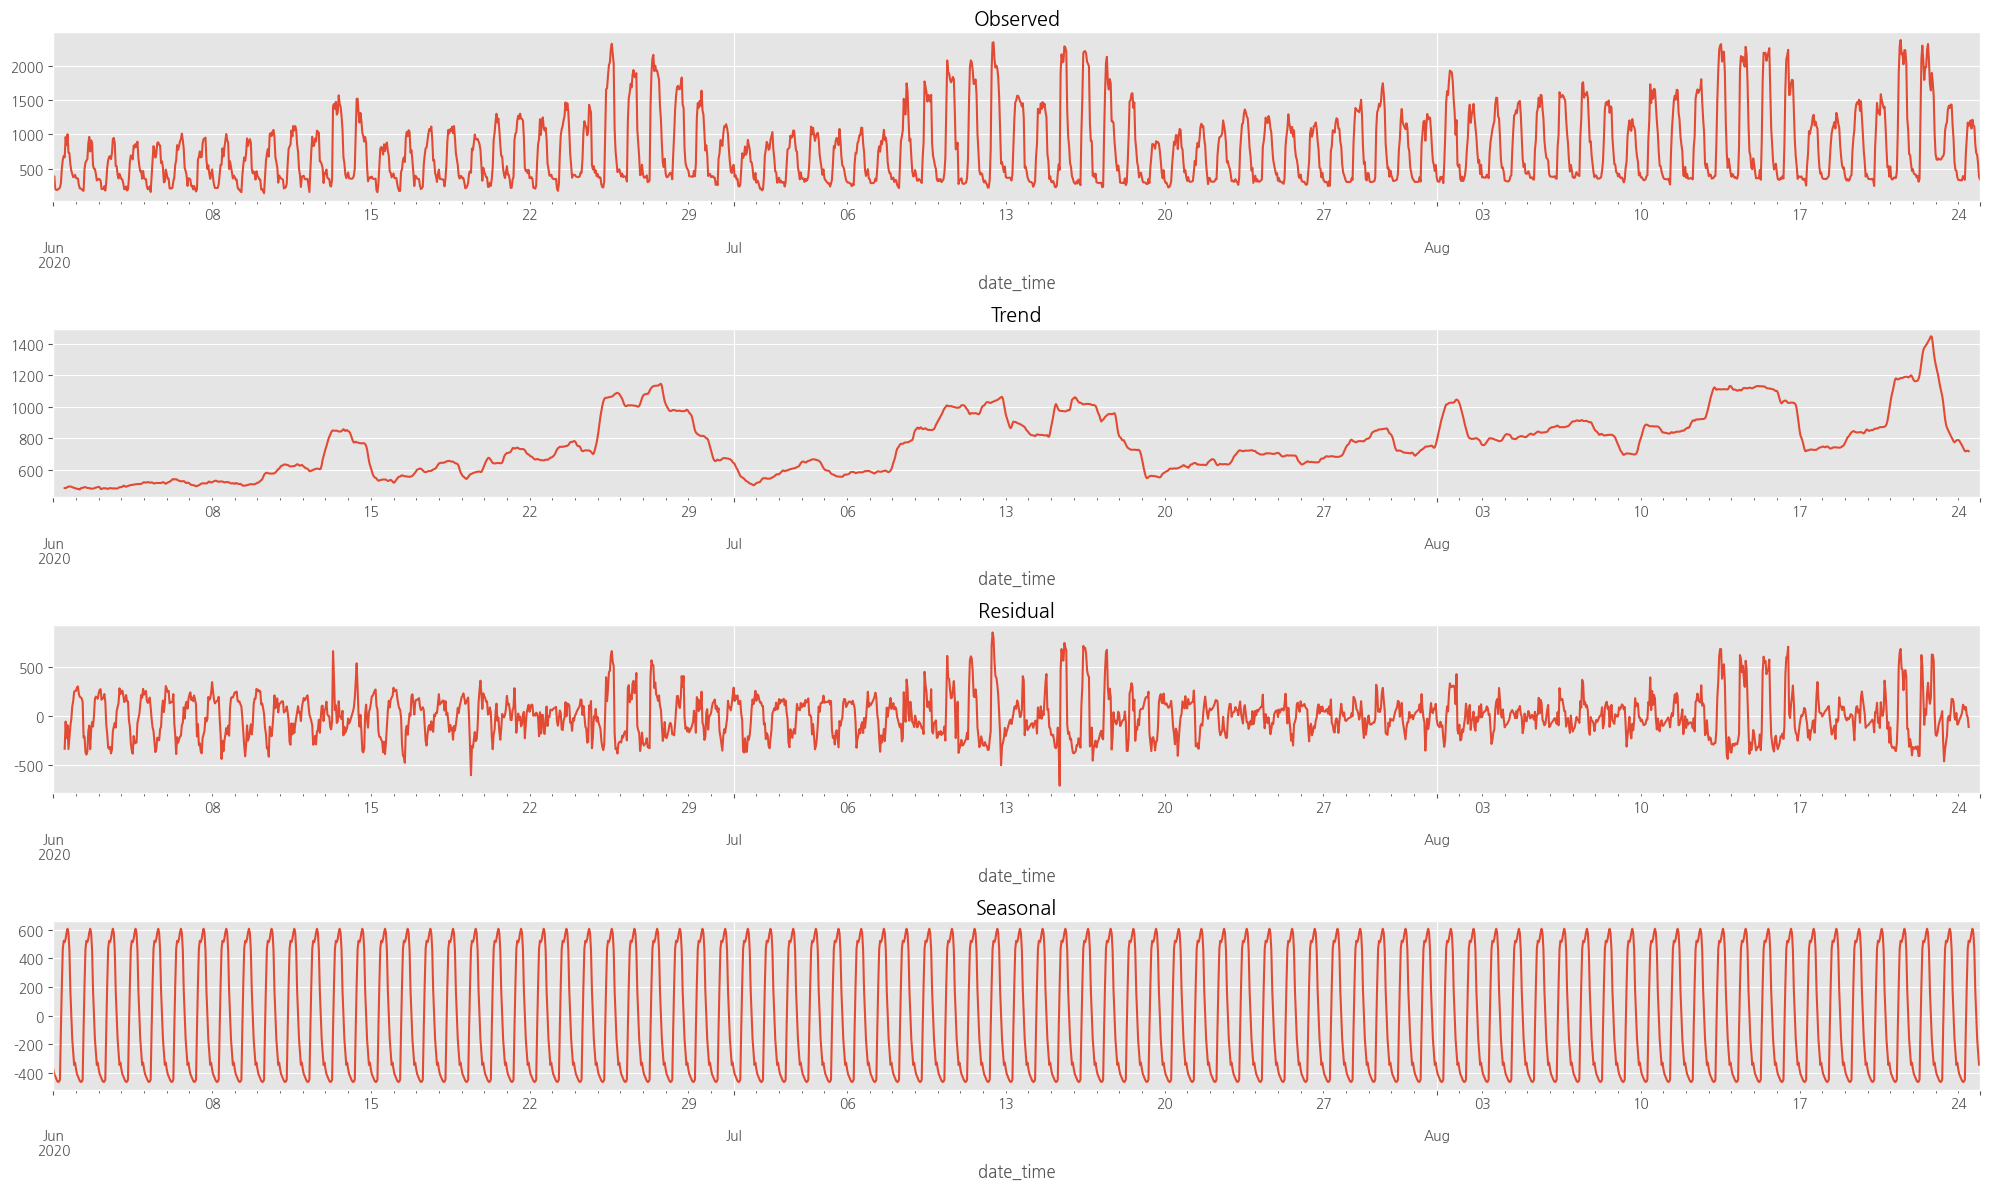

In [ ]:
## 건물4
vis_time_series_decompose(num=4)

## 2-1.정상성 변환

In [ ]:
train

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,month,day,hour,weekend
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,6.0,1.0,0.0,0.0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,6.0,1.0,1.0,0.0
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,6.0,1.0,2.0,0.0
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,6.0,1.0,3.0,0.0
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,6.0,1.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19:00:00,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0,8.0,24.0,19.0,0.0
122396,60,2020-08-24 20:00:00,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0,8.0,24.0,20.0,0.0
122397,60,2020-08-24 21:00:00,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0,8.0,24.0,21.0,0.0
122398,60,2020-08-24 22:00:00,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0,8.0,24.0,22.0,0.0


In [ ]:

# datetime 열을 인덱스로 설정
train.set_index('date_time', inplace=True)

# 전력사용량(kWh) 데이터만 추출
power_consumption = train['전력사용량(kWh)']

print(power_consumption.head())  # 데이터프레임의 처음 몇 개 행 출력

# 정상성 변환 테스트
adf = adfuller(power_consumption, regression='ct')  # 변환 전 ct 사용
print("검정통계량: {}".format(adf[0]))
print("유의확률: {}".format(adf[1]))

date_time
2020-06-01 00:00:00    8179.056
2020-06-01 01:00:00    8135.640
2020-06-01 02:00:00    8107.128
2020-06-01 03:00:00    8048.808
2020-06-01 04:00:00    8043.624
Name: 전력사용량(kWh), dtype: float64
검정통계량: -6.739638784040694
유의확률: 5.437045406719483e-08


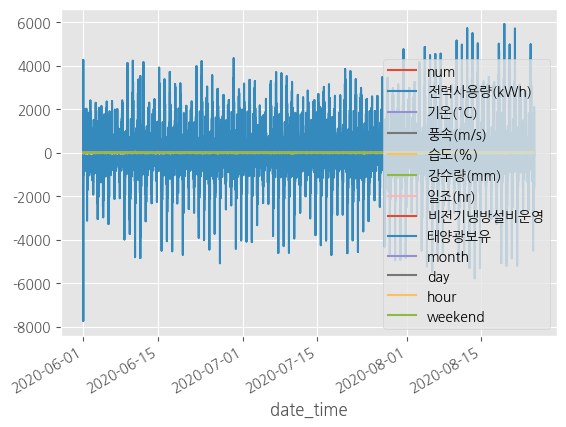

In [ ]:
# 1차 차분
diff_df = train.diff(1)
diff_df = diff_df.dropna()
diff_df.plot()
plt.show()

In [ ]:
train.diff(1).head()

,num,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,month,day,hour,weekend
date_time,,,,,,,,,,,,,
2020-06-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-01 01:00:00,0.0,-43.416,0.1,0.4,-1.0,-0.5,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2020-06-01 02:00:00,0.0,-28.512,-0.2,0.3,0.0,-0.3,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2020-06-01 03:00:00,0.0,-58.320,-0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2020-06-01 04:00:00,0.0,-5.184,-0.1,0.1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
diff_series = diff_df['전력사용량(kWh)']
adf = adfuller(diff_series, regression = 'c')
print("검정통계량: {}".format(adf[0]))
print("유의확률: {}".format(adf[1]))

검정통계량: -50.38150149242231
유의확률: 0.0
